In [1]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [2]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors

def torch_data_from_noisy_generators(dataset_generators):
    tensors = list()
    for dataset_generator in dataset_generators:
        # convert this from arr to tensor after numpy change
        original_arr = dataset_generator.samples
        denoised_arr = dataset_generator.wave
        assert original_arr.shape == denoised_arr.shape, f'{original_arr.shape} != {denoised_arr.shape}'
        original_tensor = torch.from_numpy(original_arr)
        denoised_tensor = torch.from_numpy(denoised_arr)
        tensors.append((original_tensor, denoised_tensor))
            
    original_tensors, denoised_tensors = zip(*tensors)
    original_tensor = torch.cat(original_tensors, dim=0).unsqueeze(axis=1).double()
    denoised_tensor = torch.cat(denoised_tensors, dim=0).double()
    return original_tensor, denoised_tensor
    
class TorchDenoisingDataset(Dataset):
    def __init__(self, input_tensor, output_tensor):
        assert input_tensor.shape[0] == output_tensor.shape[0], f'{input_tensor.shape} != {output_tensor.shape[0]}'
        self._original = input_tensor
        self._denoised = output_tensor
        return
    
    @property
    def shape(self):
        return self._original.shape

    def __len__(self):
        return self._original.shape[0]

    def __getitem__(self, index):
        original = self._original[index]
        denoised = self._denoised[index]
        return original, denoised

In [3]:
large_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5)
small_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.05).t_noise(std=.01, dof=5)
flat_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.005).t_noise(std=.01, dof=5)

dataset_samples = 10_000
dataset_generators = [
    large_wave_gen.sample(dataset_samples),
    small_wave_gen.sample(dataset_samples),
    flat_wave_gen.sample(dataset_samples),
]

In [4]:
original, denoised = torch_data_from_noisy_generators(dataset_generators)
train_original, test_original, train_denoised, test_denoised = torch_train_test_split(original, denoised, split=.8)

train_dataset = TorchDenoisingDataset(train_original, train_denoised)
test_dataset = TorchDenoisingDataset(test_original, test_denoised)

In [5]:
class SineDAE(nn.Module):
    def __init__(
        self, 
        input_size, 
        out_channels=16, 
        kernel_size=2, 
        stride=4, 
        pool_kernel=4, 
        drop=.4, 
        alpha=.2,
    ):
        super(SineDAE, self).__init__()
        conv1_shape = (input_size - kernel_size) // stride + 1
        pool_shape = (conv1_shape - pool_kernel) // pool_kernel + 1
        conv1t_shape = (out_channels - 1) * stride + (kernel_size - 1) + 1
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
            nn.LeakyReLU(negative_slope=alpha),
            nn.MaxPool1d(kernel_size=pool_kernel),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(pool_shape, 1, kernel_size, stride=stride),
            nn.LeakyReLU(negative_slope=alpha),
            nn.Linear(conv1t_shape, input_size + 1),
        )
    
        print(self.decoder[0])
    
        return
        
    def forward(self, x):
        x_enc = self.encoder(x)
#         display(x_enc.shape)
        x_enc = x_enc.transpose(1, 2)
#         display(x_enc.shape)
        x_dec = self.decoder(x_enc).squeeze(dim=1)
        return x_dec

In [6]:
def train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        p = print_ & True
        for (train_original, train_denoised), (test_original, test_denoised) in zip(train_dataloader, test_dataloader):
            optimizer.zero_grad()
            train_output = model(train_original)
            
            assert train_output.shape == train_denoised.shape, f'{train_output.shape} != {train_denoised.shape}'
            train_loss = criterion(train_output, train_denoised)       
            train_loss.backward()
            optimizer.step()

            test_output = model(test_original)
            test_loss = criterion(test_output, test_denoised)

            if p and not epoch % 10:
                print('Train Loss', train_loss.item())
                print('Test Loss', test_loss.item())
                p = False
                
        if test_full:
            train_original, train_denoised = train_dataset[:]
            test_original, test_denoised = test_dataset[:]
            train_output = model(train_original)
            train_loss = criterion(train_output, train_denoised)
            test_output = model(test_original)
            test_loss = criterion(test_output, test_denoised)
            if early_stop_patience:
                if test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[:-early_stop_patience]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((train_loss.item(), test_loss.item()))
    return model, items

def plot_loss(items, title='', step=1):
    plt.figure(figsize=(16,8))
    train_loss, test_loss = zip(*items)
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[3], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [7]:
out_channelss = [1,2,4]
kernel_sizes = [4,8,`6,32]
strides = [4,16,32,64,128]
pool_kernels = [16,32,128,192,256]

total_i = np.prod((len(out_channelss), len(kernel_sizes), len(strides), len(pool_kernels)))

columns = ['out_channels','kernel_size','stride','pool_kernel','train_loss','test_loss']
rows = list()
n_epochs = 30
batch_size = 128
for i, (out_channels, kernel_size, stride, pool_kernel) in enumerate(itertools.product(out_channelss, kernel_sizes, strides, pool_kernels)):
    if stride is None:
        stride = kernel_size
    if stride > kernel_size or stride > pool_kernel:
        continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(out_channels, kernel_size, stride, pool_kernel, sep='|')
    
    model = SineDAE(
        train_dataset.shape[2] - 1,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        pool_kernel=pool_kernel,
    ).double()
    
    try:
        model, items = train(
            model, 
            train_dataset, 
            test_dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        )
    except RuntimeError as re:
        warnings.warn(str(re))
        continue
        
    if not len(items):
        print('Missing loss')
        continue
    train_loss, test_loss = zip(*items)
    train_loss = np.mean(train_loss[2:])
    test_loss = np.mean(test_loss[2:])
    
    rows.append((out_channels, kernel_size, stride, pool_kernel, train_loss, test_loss))

Input Set 1 out of 600
1|8|1|4
ConvTranspose1d(248, 1, kernel_size=(8,), stride=(1,))


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Input Set 2 out of 600
1|8|1|8
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(1,))
Input Set 3 out of 600
1|8|1|16
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(1,))
Missing loss
Input Set 4 out of 600
1|8|1|32
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(1,))
Input Set 5 out of 600
1|8|1|128
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(1,))
Input Set 6 out of 600
1|8|2|4
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(2,))
Input Set 7 out of 600
1|8|2|8
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(2,))
Input Set 8 out of 600
1|8|2|16
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(2,))
Missing loss
Input Set 9 out of 600
1|8|2|32
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(2,))
Missing loss
Input Set 10 out of 600
1|8|2|128
ConvTranspose1d(3, 1, kernel_size=(8,), stride=(2,))
Missing loss
Input Set 11 out of 600
1|8|4|4
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(4,))
Input Set 12 out of 600
1|8|4|8
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(4,))
In

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (1x1x61). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (1x1x31). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 54 out of 600
1|32|32|32
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 55 out of 600
1|32|32|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 61 out of 600
1|64|1|4
ConvTranspose1d(234, 1, kernel_size=(64,), stride=(1,))
Input Set 62 out of 600
1|64|1|8
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(1,))
Input Set 63 out of 600
1|64|1|16
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(1,))
Input Set 64 out of 600
1|64|1|32
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(1,))
Input Set 65 out of 600
1|64|1|128
ConvTranspose1d(7, 1, kernel_size=(64,), stride=(1,))
Input Set 66 out of 600
1|64|2|4
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(2,))
Input Set 67 out of 600
1|64|2|8
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(2,))
Input Set 68 out of 600
1|64|2|16
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(2,))
Input Set 69 out of 600
1|64|2|32
ConvTranspose1d(14, 1, kernel_size=(64,), stride=(2,))
Input Set 70 out of

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (1x1x59). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (1x1x30). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (1x1x15). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 92 out of 600
1|128|1|8
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(1,))
Input Set 93 out of 600
1|128|1|16
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(1,))
Input Set 94 out of 600
1|128|1|32
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(1,))
Input Set 95 out of 600
1|128|1|128
ConvTranspose1d(6, 1, kernel_size=(128,), stride=(1,))
Input Set 96 out of 600
1|128|2|4
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(2,))
Input Set 97 out of 600
1|128|2|8
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(2,))
Input Set 98 out of 600
1|128|2|16
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(2,))
Input Set 99 out of 600
1|128|2|32
ConvTranspose1d(13, 1, kernel_size=(128,), stride=(2,))
Input Set 100 out of 600
1|128|2|128
ConvTranspose1d(3, 1, kernel_size=(128,), stride=(2,))
Input Set 101 out of 600
1|128|4|4
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(4,))
Input Set 102 out of 600
1|128|4|8
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(4,))

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (1x1x55). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (1x1x28). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (1x1x14). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 122 out of 600
2|8|1|8
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(1,))
Input Set 123 out of 600
2|8|1|16
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(1,))
Input Set 124 out of 600
2|8|1|32
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(1,))
Input Set 125 out of 600
2|8|1|128
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(1,))
Missing loss
Input Set 126 out of 600
2|8|2|4
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(2,))
Input Set 127 out of 600
2|8|2|8
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(2,))
Input Set 128 out of 600
2|8|2|16
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(2,))
Missing loss
Input Set 129 out of 600
2|8|2|32
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(2,))
Missing loss
Input Set 130 out of 600
2|8|2|128
ConvTranspose1d(3, 1, kernel_size=(8,), stride=(2,))
Input Set 131 out of 600
2|8|4|4
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(4,))
Input Set 132 out of 600
2|8|4|8
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(4

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (2x1x61). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (2x1x31). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 182 out of 600
2|64|1|8
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(1,))
Input Set 183 out of 600
2|64|1|16
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(1,))
Input Set 184 out of 600
2|64|1|32
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(1,))
Input Set 185 out of 600
2|64|1|128
ConvTranspose1d(7, 1, kernel_size=(64,), stride=(1,))
Input Set 186 out of 600
2|64|2|4
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(2,))
Input Set 187 out of 600
2|64|2|8
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(2,))
Input Set 188 out of 600
2|64|2|16
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(2,))
Input Set 189 out of 600
2|64|2|32
ConvTranspose1d(14, 1, kernel_size=(64,), stride=(2,))
Input Set 190 out of 600
2|64|2|128
ConvTranspose1d(3, 1, kernel_size=(64,), stride=(2,))
Input Set 191 out of 600
2|64|4|4
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(4,))
Input Set 192 out of 600
2|64|4|8
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(4,))
Input Set 193

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (2x1x59). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (2x1x30). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (2x1x15). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 212 out of 600
2|128|1|8
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(1,))
Input Set 213 out of 600
2|128|1|16
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(1,))
Input Set 214 out of 600
2|128|1|32
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(1,))
Input Set 215 out of 600
2|128|1|128
ConvTranspose1d(6, 1, kernel_size=(128,), stride=(1,))
Input Set 216 out of 600
2|128|2|4
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(2,))
Input Set 217 out of 600
2|128|2|8
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(2,))
Input Set 218 out of 600
2|128|2|16
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(2,))
Input Set 219 out of 600
2|128|2|32
ConvTranspose1d(13, 1, kernel_size=(128,), stride=(2,))
Input Set 220 out of 600
2|128|2|128
ConvTranspose1d(3, 1, kernel_size=(128,), stride=(2,))
Input Set 221 out of 600
2|128|4|4
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(4,))
Input Set 222 out of 600
2|128|4|8
ConvTranspose1d(27, 1, kernel_size=(128,), stri

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (2x1x55). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (2x1x28). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (2x1x14). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 242 out of 600
4|8|1|8
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(1,))
Input Set 243 out of 600
4|8|1|16
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(1,))
Input Set 244 out of 600
4|8|1|32
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(1,))
Input Set 245 out of 600
4|8|1|128
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(1,))
Missing loss
Input Set 246 out of 600
4|8|2|4
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(2,))
Input Set 247 out of 600
4|8|2|8
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(2,))
Input Set 248 out of 600
4|8|2|16
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(2,))
Missing loss
Input Set 249 out of 600
4|8|2|32
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(2,))
Input Set 250 out of 600
4|8|2|128
ConvTranspose1d(3, 1, kernel_size=(8,), stride=(2,))
Input Set 251 out of 600
4|8|4|4
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(4,))
Input Set 252 out of 600
4|8|4|8
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(4,))
Missing l

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (4x1x61). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (4x1x31). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 302 out of 600
4|64|1|8
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(1,))
Input Set 303 out of 600
4|64|1|16
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(1,))
Input Set 304 out of 600
4|64|1|32
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(1,))
Input Set 305 out of 600
4|64|1|128
ConvTranspose1d(7, 1, kernel_size=(64,), stride=(1,))
Input Set 306 out of 600
4|64|2|4
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(2,))
Input Set 307 out of 600
4|64|2|8
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(2,))
Input Set 308 out of 600
4|64|2|16
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(2,))
Input Set 309 out of 600
4|64|2|32
ConvTranspose1d(14, 1, kernel_size=(64,), stride=(2,))
Input Set 310 out of 600
4|64|2|128
ConvTranspose1d(3, 1, kernel_size=(64,), stride=(2,))
Missing loss
Input Set 311 out of 600
4|64|4|4
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(4,))
Input Set 312 out of 600
4|64|4|8
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (4x1x59). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (4x1x30). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (4x1x15). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 332 out of 600
4|128|1|8
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(1,))
Input Set 333 out of 600
4|128|1|16
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(1,))
Input Set 334 out of 600
4|128|1|32
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(1,))
Input Set 335 out of 600
4|128|1|128
ConvTranspose1d(6, 1, kernel_size=(128,), stride=(1,))
Input Set 336 out of 600
4|128|2|4
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(2,))
Input Set 337 out of 600
4|128|2|8
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(2,))
Input Set 338 out of 600
4|128|2|16
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(2,))
Input Set 339 out of 600
4|128|2|32
ConvTranspose1d(13, 1, kernel_size=(128,), stride=(2,))
Input Set 340 out of 600
4|128|2|128
ConvTranspose1d(3, 1, kernel_size=(128,), stride=(2,))
Input Set 341 out of 600
4|128|4|4
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(4,))
Input Set 342 out of 600
4|128|4|8
ConvTranspose1d(27, 1, kernel_size=(128,), stri

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (4x1x55). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (4x1x28). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (4x1x14). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 362 out of 600
8|8|1|8
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(1,))
Input Set 363 out of 600
8|8|1|16
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(1,))
Input Set 364 out of 600
8|8|1|32
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(1,))
Input Set 365 out of 600
8|8|1|128
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(1,))
Input Set 366 out of 600
8|8|2|4
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(2,))
Input Set 367 out of 600
8|8|2|8
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(2,))
Input Set 368 out of 600
8|8|2|16
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(2,))
Input Set 369 out of 600
8|8|2|32
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(2,))
Missing loss
Input Set 370 out of 600
8|8|2|128
ConvTranspose1d(3, 1, kernel_size=(8,), stride=(2,))
Input Set 371 out of 600
8|8|4|4
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(4,))
Input Set 372 out of 600
8|8|4|8
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(4,))
Input Set 373 out of 6

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (8x1x61). Calculated output size: (8x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (8x1x31). Calculated output size: (8x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 422 out of 600
8|64|1|8
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(1,))
Input Set 423 out of 600
8|64|1|16
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(1,))
Input Set 424 out of 600
8|64|1|32
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(1,))
Input Set 425 out of 600
8|64|1|128
ConvTranspose1d(7, 1, kernel_size=(64,), stride=(1,))
Input Set 426 out of 600
8|64|2|4
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(2,))
Input Set 427 out of 600
8|64|2|8
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(2,))
Input Set 428 out of 600
8|64|2|16
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(2,))
Input Set 429 out of 600
8|64|2|32
ConvTranspose1d(14, 1, kernel_size=(64,), stride=(2,))
Input Set 430 out of 600
8|64|2|128
ConvTranspose1d(3, 1, kernel_size=(64,), stride=(2,))
Missing loss
Input Set 431 out of 600
8|64|4|4
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(4,))
Input Set 432 out of 600
8|64|4|8
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (8x1x59). Calculated output size: (8x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (8x1x30). Calculated output size: (8x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (8x1x15). Calculated output size: (8x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 452 out of 600
8|128|1|8
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(1,))
Input Set 453 out of 600
8|128|1|16
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(1,))
Input Set 454 out of 600
8|128|1|32
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(1,))
Input Set 455 out of 600
8|128|1|128
ConvTranspose1d(6, 1, kernel_size=(128,), stride=(1,))
Input Set 456 out of 600
8|128|2|4
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(2,))
Input Set 457 out of 600
8|128|2|8
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(2,))
Input Set 458 out of 600
8|128|2|16
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(2,))
Input Set 459 out of 600
8|128|2|32
ConvTranspose1d(13, 1, kernel_size=(128,), stride=(2,))
Input Set 460 out of 600
8|128|2|128
ConvTranspose1d(3, 1, kernel_size=(128,), stride=(2,))
Input Set 461 out of 600
8|128|4|4
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(4,))
Input Set 462 out of 600
8|128|4|8
ConvTranspose1d(27, 1, kernel_size=(128,), stri

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (8x1x55). Calculated output size: (8x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (8x1x28). Calculated output size: (8x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (8x1x14). Calculated output size: (8x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 482 out of 600
16|8|1|8
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(1,))
Missing loss
Input Set 483 out of 600
16|8|1|16
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(1,))
Input Set 484 out of 600
16|8|1|32
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(1,))
Missing loss
Input Set 485 out of 600
16|8|1|128
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(1,))
Input Set 486 out of 600
16|8|2|4
ConvTranspose1d(124, 1, kernel_size=(8,), stride=(2,))
Input Set 487 out of 600
16|8|2|8
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(2,))
Input Set 488 out of 600
16|8|2|16
ConvTranspose1d(31, 1, kernel_size=(8,), stride=(2,))
Input Set 489 out of 600
16|8|2|32
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(2,))
Input Set 490 out of 600
16|8|2|128
ConvTranspose1d(3, 1, kernel_size=(8,), stride=(2,))
Missing loss
Input Set 491 out of 600
16|8|4|4
ConvTranspose1d(62, 1, kernel_size=(8,), stride=(4,))
Input Set 492 out of 600
16|8|4|8
ConvTranspose1d(31, 1, kernel_size=(8,)

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (16x1x61). Calculated output size: (16x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (16x1x31). Calculated output size: (16x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 542 out of 600
16|64|1|8
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(1,))
Input Set 543 out of 600
16|64|1|16
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(1,))
Input Set 544 out of 600
16|64|1|32
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(1,))
Input Set 545 out of 600
16|64|1|128
ConvTranspose1d(7, 1, kernel_size=(64,), stride=(1,))
Input Set 546 out of 600
16|64|2|4
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(2,))
Input Set 547 out of 600
16|64|2|8
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(2,))
Input Set 548 out of 600
16|64|2|16
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(2,))
Input Set 549 out of 600
16|64|2|32
ConvTranspose1d(14, 1, kernel_size=(64,), stride=(2,))
Input Set 550 out of 600
16|64|2|128
ConvTranspose1d(3, 1, kernel_size=(64,), stride=(2,))
Input Set 551 out of 600
16|64|4|4
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(4,))
Input Set 552 out of 600
16|64|4|8
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(4,))
In

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (16x1x59). Calculated output size: (16x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (16x1x30). Calculated output size: (16x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (16x1x15). Calculated output size: (16x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 572 out of 600
16|128|1|8
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(1,))
Input Set 573 out of 600
16|128|1|16
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(1,))
Input Set 574 out of 600
16|128|1|32
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(1,))
Input Set 575 out of 600
16|128|1|128
ConvTranspose1d(6, 1, kernel_size=(128,), stride=(1,))
Input Set 576 out of 600
16|128|2|4
ConvTranspose1d(109, 1, kernel_size=(128,), stride=(2,))
Input Set 577 out of 600
16|128|2|8
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(2,))
Input Set 578 out of 600
16|128|2|16
ConvTranspose1d(27, 1, kernel_size=(128,), stride=(2,))
Input Set 579 out of 600
16|128|2|32
ConvTranspose1d(13, 1, kernel_size=(128,), stride=(2,))
Input Set 580 out of 600
16|128|2|128
ConvTranspose1d(3, 1, kernel_size=(128,), stride=(2,))
Input Set 581 out of 600
16|128|4|4
ConvTranspose1d(54, 1, kernel_size=(128,), stride=(4,))
Input Set 582 out of 600
16|128|4|8
ConvTranspose1d(27, 1, kernel_size=(

C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (16x1x55). Calculated output size: (16x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (16x1x28). Calculated output size: (16x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_21664\1636963385.py:40: UserWarning: Given input size: (16x1x14). Calculated output size: (16x1x0). Output size is too small
  warnings.warn(str(re))


In [8]:
grid_df = pd.DataFrame(rows)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

,out_channels,kernel_size,stride,pool_kernel,train_loss,test_loss
0,1,8,1,4,NaN,NaN
1,1,8,1,8,NaN,NaN
2,1,8,1,32,NaN,NaN
3,1,8,1,128,NaN,NaN
4,1,8,2,4,0.001269,0.001291
...,...,...,...,...,...,...
296,16,128,4,16,0.000577,0.000576
297,16,128,4,32,0.001340,0.001357
298,16,128,4,128,0.000069,0.000068
299,16,128,16,16,0.089343,0.091417


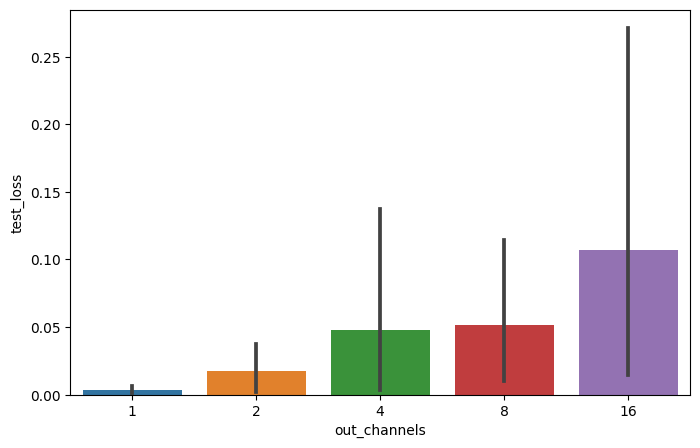

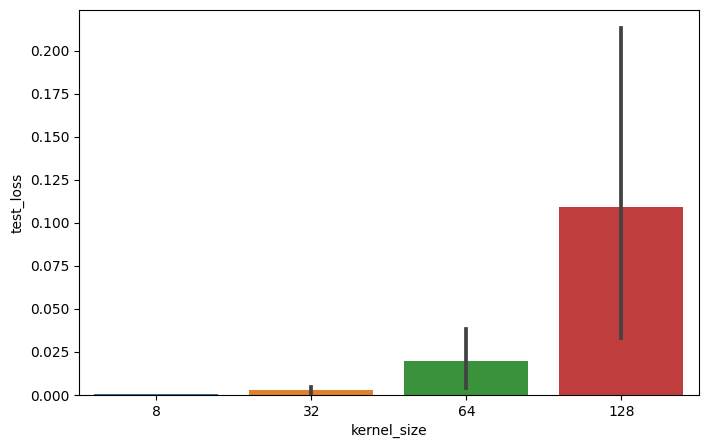

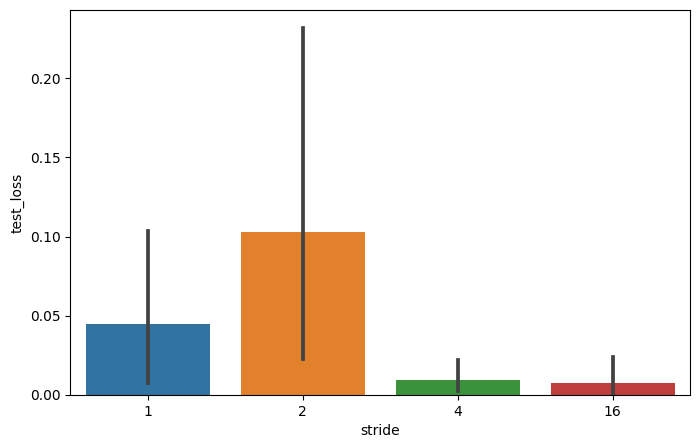

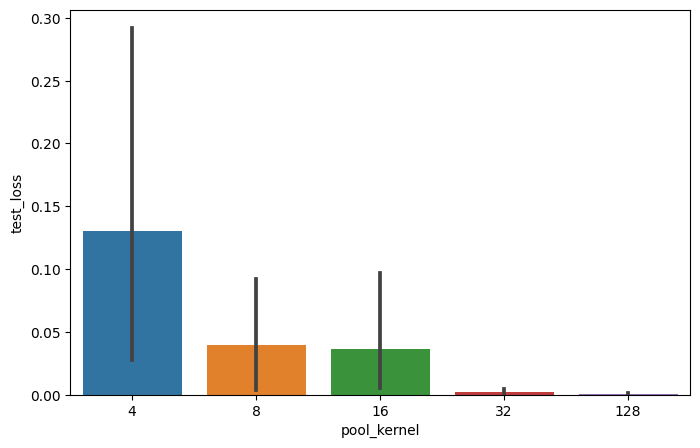

In [9]:
for col in ['out_channels','kernel_size','stride','pool_kernel']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

In [ ]:
best_out_channels, best_kernel_size, best_stride, best_pool_kernel = grid_df.iloc[grid_df['test_loss'].argmin(),:4].to_numpy(dtype=np.int32)

# display(best_out_channels, best_kernel_size, best_stride, best_pool_kernel)
model = SineDAE(
    train_dataset.shape[2] - 1,
    out_channels=best_out_channels,
    kernel_size=best_kernel_size,
    stride=best_stride,
    pool_kernel=best_pool_kernel,
).double()

model, items = train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=100, 
    test_full=True, 
    early_stop_patience=None,
) 
plot_loss(
    items,
    title=''
)
torch.save(model, 'best_dae_model.pt')

ConvTranspose1d(3, 1, kernel_size=(32,), stride=(2,))


In [ ]:
for i in np.random.choice(test_dataset.shape[0], size=5):
    x, y = test_dataset[i]
    
    z = model(x.unsqueeze(dim=1)).detach().numpy().squeeze()
    x = x.squeeze()

    plt.figure(figsize=(16,8))
    plt.plot(x, color='blue', label='Original')
    plt.plot(y, color='red', label='Ground Truth')
    plt.plot(z, color='purple', label='Predicted')
    plt.legend()
    plt.show()